# Load and parse data with TensorFlow 2.0 (tf.data) - 用tensorflow2.0（tf.data）加载和解析数据

A TensorFlow 2.0 example to build input pipelines for loading data efficiently.

这是一个用TensorFlow 2.0构建高效输入管道并加载数据的示例。

- Numpy Arrays - 加载numpy数组
- Images - 加载图片
- CSV file - 加载CSV文件（表格）
- Custom data from a Generator - 从生成器加载自定义数据

For more information about creating and loading TensorFlow's `TFRecords` data format, see: [tfrecords.ipynb](tfrecords.ipynb)

有关创建和加载TensorFlow的`TFRecords`数据格式的更多信息，请参见：[tfrecords.ipynb](tfrecords.ipynb)

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [70]:
from __future__ import absolute_import, division, print_function

import numpy as np
import random
import requests
import string
import tarfile
import tensorflow as tf

### Load Numpy Arrays - 加载numpy数组

Build a data pipeline over numpy arrays.

构建一个用于numpy数组的数据管道。


In [71]:
# Create a toy dataset (even and odd numbers, with respective labels of 0 and 1).
# 创建一个测试用的数据集（偶数和奇数，分别用0和1标记）
evens = np.arange(0, 100, step=2, dtype=np.int32) # 0, 2, 4, 6, ..., 98，偶数ndarray
evens_label = np.zeros(50, dtype=np.int32) # 50个0，偶数标签ndarray
odds = np.arange(1, 100, step=2, dtype=np.int32) # 1, 3, 5, 7, ..., 99，奇数ndarray
odds_label = np.ones(50, dtype=np.int32) # 50个1，奇数标签ndarray
# Concatenate arrays - 连接偶数和奇数的ndarray
features = np.concatenate([evens, odds])
labels = np.concatenate([evens_label, odds_label])

# Load a numpy array using tf data api with `from_tensor_slices`.
# 使用tf data api加载numpy数组
# 译者注：from_tensor_slices直译是“从张量切片”，即输入张量数组和标签张量数组的元组，意为从张量切片创建数据集。其返回一个tf.data.Dataset对象。
data = tf.data.Dataset.from_tensor_slices((features, labels))
# Refill data indefinitely. - 无限重复数据 （这里只是重复了索引，不是真正的复制多份数据）
data = data.repeat()
# Shuffle data. - 打乱数据
data = data.shuffle(buffer_size=100)
# Batch data (aggregate records together). - 数据分批
data = data.batch(batch_size=4)
# Prefetch batch (pre-load batch for faster consumption). - 预加载数据，可以在一批数据训练的同时预加载下一批数据，可以加快训练速度，但是会占用更多内存
data = data.prefetch(buffer_size=1)

In [72]:
for batch_x, batch_y in data.take(5):
    print(batch_x, batch_y) # 取5批数据看看

tf.Tensor([73  1 65  5], shape=(4,), dtype=int32) tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
tf.Tensor([23 36 26 90], shape=(4,), dtype=int32) tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor([14 99 12 12], shape=(4,), dtype=int32) tf.Tensor([0 1 0 0], shape=(4,), dtype=int32)
tf.Tensor([45 28 72 16], shape=(4,), dtype=int32) tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor([81 78 18 64], shape=(4,), dtype=int32) tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)


In [73]:
# Note: If you are planning on calling multiple time,
# you can user the iterator way:
# 注意：如果你打算多次调用，可以使用迭代器的方式
# 译者注：这里是使用iter()函数创建一个迭代器，然后使用next()函数获取下一个元素。这么做的好处是可以在需要的时候获取下一个元素，而不是一次性获取所有元素。并且可以记录当前的迭代位置。
ite_data = iter(data)
for i in range(5):
    batch_x, batch_y = next(ite_data)
    print(batch_x, batch_y)

for i in range(5):
    batch_x, batch_y = next(ite_data)
    print(batch_x, batch_y)

tf.Tensor([77 11 85  9], shape=(4,), dtype=int32) tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
tf.Tensor([95 12 92 74], shape=(4,), dtype=int32) tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor([82 36  0  8], shape=(4,), dtype=int32) tf.Tensor([0 0 0 0], shape=(4,), dtype=int32)
tf.Tensor([87 75 59 55], shape=(4,), dtype=int32) tf.Tensor([1 1 1 1], shape=(4,), dtype=int32)
tf.Tensor([93 26  7 84], shape=(4,), dtype=int32) tf.Tensor([1 0 1 0], shape=(4,), dtype=int32)
tf.Tensor([ 2 21 88 25], shape=(4,), dtype=int32) tf.Tensor([0 1 0 1], shape=(4,), dtype=int32)
tf.Tensor([ 5 10 53 24], shape=(4,), dtype=int32) tf.Tensor([1 0 1 0], shape=(4,), dtype=int32)
tf.Tensor([40 18  8 28], shape=(4,), dtype=int32) tf.Tensor([0 0 0 0], shape=(4,), dtype=int32)
tf.Tensor([70 43 48 13], shape=(4,), dtype=int32) tf.Tensor([0 1 0 1], shape=(4,), dtype=int32)
tf.Tensor([22 94 52 24], shape=(4,), dtype=int32) tf.Tensor([0 0 0 0], shape=(4,), dtype=int32)


### Load CSV files - 加载CSV表格

Build a data pipeline from features stored in a CSV file. For this example, Titanic dataset will be used as a toy dataset stored in CSV format.

构建一个将特征存储在CSV表格文件中的数据加载管道。此示例将使用Titanic数据集，它是存储在CSV格式中的测试用数据集。

#### Titanic Dataset - 泰坦尼克号数据集



survived-是否存活|pclass-客舱等级|name-名字|sex-性别|age-年龄|sibsp-同行兄弟姐妹及配偶数量|parch-同行父母及子女|船票号码|船票价格
--------|------|----|---|---|-----|-----|------|----
1|1|"Allen, Miss. Elisabeth Walton"|female|29|0|0|24160|211.3375
1|1|"Allison, Master. Hudson Trevor"|male|0.9167|1|2|113781|151.5500
0|1|"Allison, Miss. Helen Loraine"|female|2|1|2|113781|151.5500
0|1|"Allison, Mr. Hudson Joshua Creighton"|male|30|1|2|113781|151.5500
...|...|...|...|...|...|...|...|...

In [74]:
# Download Titanic dataset (in csv format). - 下载泰坦尼克数据集（是一个csv表格文件）
d = requests.get("https://raw.githubusercontent.com/tflearn/tflearn.github.io/master/resources/titanic_dataset.csv")
with open("titanic_dataset.csv", "wb") as f:
    f.write(d.content) # 将从网页上读取的数据写入本地文件

In [75]:
# Load Titanic dataset. - 加载泰坦尼克数据集
# Original features: survived,pclass,name,sex,age,sibsp,parch,ticket,fare - 原始特征有这些：生存与否，船舱等级，姓名，性别，年龄，同行的兄弟姐妹配偶数，同行的父母子女数，船票号码，票价
# Select specific columns: survived,pclass,name,sex,age,fare - 选择指定的特征：生存与否，船舱等级，姓名，性别，年龄，票价
column_to_use = [0, 1, 2, 3, 4, 8]
# 译者注：这里是定义了一个默认的数据类型
record_defaults = [tf.int32, tf.int32, tf.string, tf.string, tf.float32, tf.float32]

# Load the whole dataset file, and slice each line. - 加载整个数据集文件，并切片每一行
data = tf.data.experimental.CsvDataset("titanic_dataset.csv", record_defaults, header=True, select_cols=column_to_use)
# Refill data indefinitely. - 无限重复数据
data = data.repeat()
# Shuffle data. - 打乱数据
data = data.shuffle(buffer_size=1000)
# Batch data (aggregate records together). - 数据分批
data = data.batch(batch_size=2)
# Prefetch batch (pre-load batch for faster consumption). - 预加载数据
data = data.prefetch(buffer_size=1)

In [76]:
# 打印数据中的第一条看看
for survived, pclass, name, sex, age, fare in data.take(1):
    print(survived.numpy())
    print(pclass.numpy())
    print(name.numpy())
    print(sex.numpy())
    print(age.numpy())
    print(fare.numpy())
# 译者注：这里array的长度为2是因为batch_size=2，所以每次取出的数据是2条记录
# 译者注：这里结束得有点突然，其实这里的data已经是一个tf.data.Dataset对象了，可以直接用于训练模型

[1 0]
[1 2]
[b'Chevre, Mr. Paul Romaine' b'Bryhl, Mr. Kurt Arnold Gottfrid']
[b'male' b'male']
[45. 25.]
[29.7 26. ]


### Load Images - 加载图片

Build a data pipeline by loading images from disk. For this example, Oxford Flowers dataset will be used.

构建一个通过从磁盘加载图片的数据管道。此示例将使用牛津花卉数据集。

In [77]:
# Download Oxford 17 flowers dataset. - 下载牛津17种花数据集
d = requests.get("http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz")
with open("17flowers.tgz", "wb") as f:
    f.write(d.content)
# Extract archive. - 解压下载下来的文件
with tarfile.open("17flowers.tgz") as t:
    t.extractall()

In [78]:
# 译者注：这一步是根据下载下来的所有图片生成一个dataset表格，只有两列，第一列是图片的相对路径，第二列是图片的标签
with open('jpg/dataset.csv', 'w') as f:
    c = 0
    for i in range(1360):
        f.write("jpg/image_%04i.jpg,%i\n" % (i+1, c)) # 这里的c是标签值，0-16
        if (i+1) % 80 == 0: # 每种花有80张图片
            c += 1

In [79]:
# Load Images - 加载图片
with open("jpg/dataset.csv") as f:
    dataset_file = f.read().splitlines() # dataset_file是一个列表，包含了所有图片的相对路径和标签

# Load the whole dataset file, and slice each line.
# 加载整个数据集文件，并切片每一行
data = tf.data.Dataset.from_tensor_slices(dataset_file)
# Refill data indefinitely. - 无限重复数据
data = data.repeat()
# Shuffle data. - 打乱数据
data = data.shuffle(buffer_size=1000)

# Load and pre-process images. - 加载和预处理图片
def load_image(path):
    # Read image from path. - 从路径读取图片
    image = tf.io.read_file(path)
    # Decode the jpeg image to array [0, 255]. - 解码jpeg图片为数组[0, 255]，代表灰度
    image = tf.image.decode_jpeg(image)
    # Resize images to a common size of 256x256. - 将图片调整为256x256的大小
    image = tf.image.resize(image, [256, 256])
    # Rescale values to [-1, 1]. - 将值缩放到[-1, 1]之间
    image = 1. - image / 127.5
    # image = image / 255
    return image
# Decode each line from the dataset file. - 解码数据集文件中的每一行
def parse_records(line):
    # File is in csv format: "image_path,label_id". - 文件是csv格式的：“图片相对路径，标签id”
    # TensorFlow requires a default value, but it will never be used. - TensorFlow需要一个默认值，但是它永远不会被使用
    image_path, image_label = tf.io.decode_csv(line, ["", 0])
    # Apply the function to load images. - 加载图片
    image = load_image(image_path)
    return image, image_label
# Use 'map' to apply the above functions in parallel. - 使用map函数并行地应用上面的函数
data = data.map(parse_records, num_parallel_calls=4) # 这里是把原先的数据（path，id） 转换成了（image，id），期间做了图片的加载和预处理

# Batch data (aggregate images-array together). - 数据分批（聚合图片数组）
data = data.batch(batch_size=2)
# Prefetch batch (pre-load batch for faster consumption). - 预加载数据, 加快训练速度
data = data.prefetch(buffer_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([8 9], shape=(2,), dtype=int32)


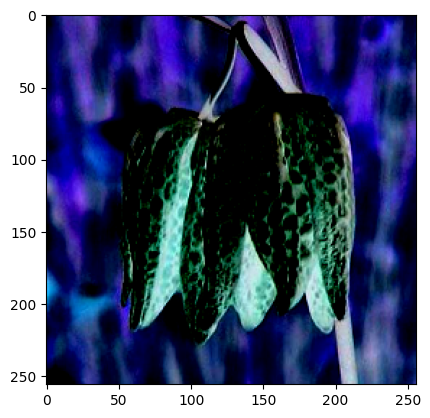

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


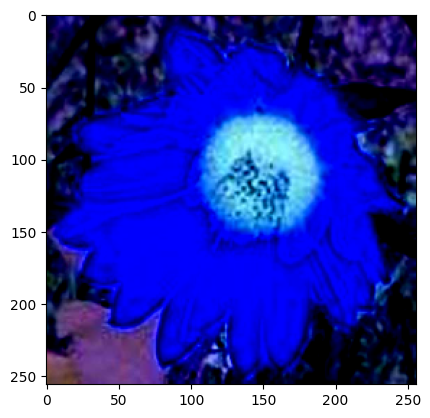

In [80]:
# 打印数据中的第一批看看
for batch_x, batch_y in data.take(1):
    print(batch_y)

import matplotlib.pyplot as plt
plt.imshow(np.reshape(batch_x[0], [256, 256, 3]))
plt.show()
plt.imshow(np.reshape(batch_x[1], [256, 256, 3]))

### Load data from a Generator - 从自定义生成器加载数据

In [81]:
# Create a dummy generator. - 创建一个虚拟生成器
def generate_features():
    # Function to generate a random string. - 生成一个随机字符串
    def random_string(length):
        return ''.join(random.choice(string.ascii_letters) for m in range(length))
    # Return a random string, a random vector, and a random int. - 返回一个随机字符串，一个随机向量，一个随机整数
    yield random_string(4), np.random.uniform(size=4), random.randint(0, 10)

In [82]:
# Load a numpy array using tf data api with `from_tensor_slices`. - 使用tf data api加载numpy数组
data = tf.data.Dataset.from_generator(generate_features, output_types=(tf.string, tf.float32, tf.int32))
# Refill data indefinitely. - 无限重复数据
data = data.repeat()
# Shuffle data. - 打乱数据
data = data.shuffle(buffer_size=100)
# Batch data (aggregate records together).  - 数据分批
data = data.batch(batch_size=4)
# Prefetch batch (pre-load batch for faster consumption).   - 预加载数据
data = data.prefetch(buffer_size=1)

In [83]:
# Display data. - 显示数据
for batch_str, batch_vector, batch_int in data.take(5):
    print(batch_str, batch_vector, batch_int)

tf.Tensor([b'vczB' b'dUHP' b'zpMd' b'NIuL'], shape=(4,), dtype=string) tf.Tensor(
[[0.07873718 0.68199533 0.50508684 0.18010655]
 [0.68189067 0.19134367 0.84725326 0.3859616 ]
 [0.7179938  0.6301553  0.5634612  0.7430664 ]
 [0.9465919  0.5970031  0.01166619 0.19001144]], shape=(4, 4), dtype=float32) tf.Tensor([10  1 10  6], shape=(4,), dtype=int32)
tf.Tensor([b'mSQf' b'PFCg' b'Oudb' b'JWQd'], shape=(4,), dtype=string) tf.Tensor(
[[0.21083604 0.7749122  0.60211235 0.00496526]
 [0.77439433 0.7757868  0.41714886 0.15435609]
 [0.8464136  0.70364344 0.83032554 0.37618104]
 [0.84422714 0.797326   0.2862765  0.27479014]], shape=(4, 4), dtype=float32) tf.Tensor([1 5 8 3], shape=(4,), dtype=int32)
tf.Tensor([b'FTYz' b'RnwN' b'KoEg' b'tLSh'], shape=(4,), dtype=string) tf.Tensor(
[[0.4319201  0.663262   0.6435594  0.4427152 ]
 [0.09761779 0.25626367 0.6468913  0.7165176 ]
 [0.29041314 0.4174205  0.24551958 0.1540281 ]
 [0.56599945 0.879646   0.03092035 0.43600562]], shape=(4, 4), dtype=float32) t